In [49]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

# Downloading MNIST dataset

In [41]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

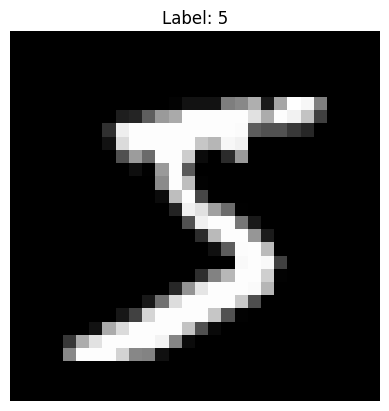

In [50]:
plt.imshow(X_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')  # Hide axes
plt.show()

# Split Data

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(48000, 28, 28) (48000,)
(12000, 28, 28) (12000,)
(10000, 28, 28) (10000,)


In [54]:
for i in range(0, 10):
    print("digit " + str(i) + " - " + str(len(np.where(y_train == i)[0])))

digit 0 - 4746
digit 1 - 5405
digit 2 - 4772
digit 3 - 4917
digit 4 - 4658
digit 5 - 4293
digit 6 - 4731
digit 7 - 5048
digit 8 - 4659
digit 9 - 4771


# Preprocessing

In [55]:
def preprocessing(img):
    img = cv2.equalizeHist(img)
    img = img/225
    return img

In [56]:
X_train_preprocessed = np.array(list(map(preprocessing, X_train)))
X_val_preprocessed = np.array(list(map(preprocessing, X_val)))
X_test_preprocessed = np.array(list(map(preprocessing, X_test)))

In [59]:
X_train_preprocessed.shape

(48000, 28, 28)

In [60]:
X_train_reshaped = X_train_preprocessed.reshape(X_train_preprocessed.shape[0], X_train_preprocessed.shape[1], X_train_preprocessed.shape[2], 1)
X_val_reshaped = X_val_preprocessed.reshape(X_val_preprocessed.shape[0], X_val_preprocessed.shape[1], X_val_preprocessed.shape[2], 1)
X_test_reshaped = X_test_preprocessed.reshape(X_test_preprocessed.shape[0], X_test_preprocessed.shape[1], X_test_preprocessed.shape[2], 1)

In [61]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range =0.1,
                                                          height_shift_range = 0.1,
                                                          zoom_range = 0.2,
                                                          shear_range = 0.1,
                                                          rotation_range = 10)

data_gen.fit(X_train_reshaped)

In [62]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, 10)
y_val_encoded = tf.keras.utils.to_categorical(y_val, 10)
y_test_encoded = tf.keras.utils.to_categorical(y_test, 10)

# Model

In [63]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(60, (5,5), input_shape=(28, 28, 1), activation='relu'))
model.add(tf.keras.layers.Conv2D(60, (5,5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(30, (3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(30, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

learning_rate = 0.001  # You can tune this value
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/Users/hasangaranasinghe/Documents/Projects/Text-Detection/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 20, 20, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 30)       │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 500)            │       135,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,490 (1001.91 KB)

 Trainable params: 256,490 (1001.91 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model = tf.keras.models.Sequential()

# Convolutional layers to extract spatial features
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten the output from the convolutional layers
model.add(tf.keras.layers.Flatten())

# Fully connected (dense) layers
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Output layer with 10 classes for digit classification
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Compile the model with a specific learning rate
learning_rate = 0.001  # You can tune this value
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,506 (541.04 KB)

 Trainable params: 138,506 (541.04 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = model.fit(
    data_gen.flow(X_train_reshaped, y_train_encoded, batch_size=50),
    steps_per_epoch=2000,
    epochs=10,
    validation_data=(X_val_reshaped, y_val_encoded),
    shuffle=True
)

Epoch 1/10
   1/2000 ━━━━━━━━━━━━━━━━━━━━ 1:12:31 2s/step - accuracy: 0.0600 - loss: 2.3045

/Users/hasangaranasinghe/Documents/Projects/Text-Detection/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 960/2000 ━━━━━━━━━━━━━━━━━━━━ 2:24 139ms/step - accuracy: 0.6617 - loss: 0.9903

/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 144s 71ms/step - accuracy: 0.7445 - loss: 0.7632 - val_accuracy: 0.9796 - val_loss: 0.0690
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 131s 66ms/step - accuracy: 0.9379 - loss: 0.2087 - val_accuracy: 0.9889 - val_loss: 0.0375
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 123s 62ms/step - accuracy: 0.9553 - loss: 0.1526 - val_accuracy: 0.9869 - val_loss: 0.0468
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 123s 62ms/step - accuracy: 0.9652 - loss: 0.1191 - val_accuracy: 0.9919 - val_loss: 0.0313
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 131s 66ms/step - accuracy: 0.9689 - loss: 0.1078 - val_accuracy: 0.9921 - val_loss: 0.0300
Epoch 6/10
 960/2000 ━━━━━━━━━━━━━━━━━━━━ 2:07 122ms/step - accuracy: 0.9717 - loss: 0.0989

2024-08-16 13:42:57.192096: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 125s 63ms/step - accuracy: 0.9717 - loss: 0.0978 - val_accuracy: 0.9920 - val_loss: 0.0286
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 132s 66ms/step - accuracy: 0.9754 - loss: 0.0860 - val_accuracy: 0.9909 - val_loss: 0.0329
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 127s 63ms/step - accuracy: 0.9767 - loss: 0.0825 - val_accuracy: 0.9936 - val_loss: 0.0265
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 121s 60ms/step - accuracy: 0.9773 - loss: 0.0800 - val_accuracy: 0.9934 - val_loss: 0.0223
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 121s 61ms/step - accuracy: 0.9793 - loss: 0.0727 - val_accuracy: 0.9919 - val_loss: 0.0295


In [66]:
score = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
score

[0.02425302192568779, 0.9926000237464905]

In [65]:
pickle_out = open("../model_trained_2.p", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

In [69]:
img = cv2.imread("../7.jpeg")
img = cv2.resize(img, (28, 28))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = preprocessing(img)
img = img.reshape(1, 28, 28, 1)
predictions = model.predict(img)
print("Prediction probabilities:", predictions)
classIndex = np.argmax(predictions, axis=1)
print(classIndex)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction probabilities: [[4.2194349e-01 4.7279946e-06 5.6120206e-02 3.6956224e-04 3.6884201e-04
  4.2217731e-04 2.6094448e-03 5.0552198e-06 5.1478100e-01 3.3754928e-03]]
[8]
